# Notebook for code presented at: https://learningml.dev/svm

In [68]:
import numpy as np
from scipy.optimize import minimize

class HardMarginSVM():

    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X, y):
        m, n = X.shape

        # function to be minimized - the argument bw is a vector [b, w_1, ..., w_n]
        get_norm = lambda bw: 0.5 * np.sum(bw[1:] ** 2)

        # these constraints force all the training set to be out of the -1 and +1 margins
        def get_constraints_value(bw):
            b = bw[0]
            w = bw[1:]
            constraint_values = []

            for idx in range(m):
                constraint_values.append((y[idx] * (X[idx:idx+1, :] @ w + b) - 1)[0])

            return constraint_values

        c = {'type': 'ineq', 'fun': get_constraints_value}

        opt = minimize(get_norm, np.zeros(n + 1), constraints=c, method='SLSQP')

        if not opt.success:
            raise Exception(f'Optimization did not converge: {opt.message}')

        self.b = opt.x[0]
        self.w = np.array(opt.x[1:]).reshape((-1, 1))

    def predict(self, X):
        return np.sign(self.b + X @ self.w).ravel()

In [69]:
from cvxopt import matrix, solvers

class SoftMarginSVM:
    
    def __init__(self, C = None):
        self.C = 1.0 if C is None else float(C)
        
    def fit(self, X, y):
        m, n = X.shape
        X_padded = np.pad(X, pad_width=((0, 0), (1, 0)), constant_values=1)
        
        # identity to get w vector back
        P = np.identity(n + 1)
        
        # zero to cancel out bias term
        P[0, 0] = 0.

        # fill with zeros to the right to cancel epsilons
        P = np.c_[P, np.zeros((n + 1, m))] 

        # fill with zeros to the botom, so that P is square (1 + n + m) x (1 + n + m)
        P = np.r_[P, np.zeros((m, 1 + n + m))]

        # 0s to cancel b and w and C to sum C * epsilon_i
        q = np.array([0.] * (n + 1) + [self.C] * m)

        # condition -y * (w.T x + b) - epsilon <= -1
        # G * u gives -y * (w.T x + b)
        G = X_padded * np.tile(-1 * y.reshape(-1, 1), n + 1)
        
        # identity gives -epsilon
        G = np.c_[G, -1 * np.identity(m)]

        # condition -epsilon_i <= 0 
        # zeros to multiply b and w - identity gives -epsilon_i
        gamma_cond = np.c_[np.zeros((m, n + 1)), np.identity(m) * -1] 

        G = np.r_[G, gamma_cond]

        h = np.r_[np.ones(m) * -1, np.zeros(m)]

        solution = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), show_progress=False)['x']
    
        self.b = solution[0]
        
        # ignore the epsilons 
        self.w = np.array(solution[1:len(solution) - m])
    
    def predict(self, X):
        return np.sign(X @ self.w + self.b).ravel()


In [70]:
# Original found on this repo: https://gist.github.com/mblondel/586753

from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def get_polynomial_kernel(p = 3):
    return lambda x1, x2: (1 + np.dot(x1, x2)) ** p

def get_rbf_kernel(gamma = 0.3):
    return lambda x1, x2: np.exp(-gamma * linalg.norm(x1 - x2) ** 2)

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix K[i, j] = K(x_i, x_j)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Outer-product gives a matrix such that [i, j] = y_i * y_j
        # Element-wise multiplication gives P, such that:
        # P[i, j] = y_i * y_j * K(x_i, x_j)
        #
        # First factor of objective function:
        # 1/2 x^T P x = 1/2 * sum(alpha_i * alpha_j * y_i * y_j * K(x_i, x_j)
        P = cvxopt.matrix(np.outer(y, y) * K)

        # 2nd factor of objective function:
        # q^T x = -1 * sum(alpha)
        q = cvxopt.matrix(np.ones(n_samples) * -1)

        # Eq constraint (Ax = b): sum(alpha * y) = 0
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # Ineq constraint (Gx <= h):
        # alpha <= C and -alpha <= 0 (equivalent to alpha >= 0)
        if self.C is None:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.identity(n_samples) * -1
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print(f'{len(self.a)} support vectors out of {n_samples} points')

        # Intercept - average over indices where 0 < alpha_i < C
        self.b = 0
        alpha_diff_C_count = 0
        is_eq_to_C = lambda a: self.C is not None and a > self.C - 1e-5

        for n in range(len(self.a)):
            if is_eq_to_C(self.a[n]):
                continue

            alpha_diff_C_count += 1
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])

        self.b = self.b / alpha_diff_C_count if alpha_diff_C_count > 0 else 0

        # Weight vector: we can't compute w if we are using a kernel
        # since the sum would be over alpha * y * phi(x), where
        # phi is the implicit mapping embedded in the kernel
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [71]:
from sklearn.datasets import make_classification, make_moons
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_scaled_linearly_separable_data(size = 100):
    separable = False
    while not separable:
        samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
        red = samples[0][samples[1] == 0]
        blue = samples[0][samples[1] == 1]
        separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
    
    X = StandardScaler().fit_transform(samples[0])
    return X, np.where(samples[1] == 0, -1, 1)

def get_scaled_moon_data():
    X, y = make_moons(n_samples=100, noise=0.1)
    X = StandardScaler().fit_transform(X)
    return X, np.where(y == 0, -1., 1.)

def plot_margins(clf, axes, with_margins=True):
    [w1, w2] = clf.w.ravel()
    b = clf.b
    
    get_x2 = lambda x1, margin: (margin - b - w1 * x1) / w2
    
    plot_x0 = np.array(axes[0:2])
    margins = [0, -1, 1] if with_margins else [0] 
    
    for margin in margins:
        alpha = 1 if margin == 0 else 0.7
        plot_x1 = get_x2(plot_x0, margin)
        plt.plot(plot_x0, plot_x1, 'k--' if margin != 0 else 'k-', alpha=alpha, zorder=-10)
    
    plt.axis(axes)
    
def plot_scatter(x1, x2, y, s=55):
    plt.scatter(x1[y == -1], x2[y == -1], marker='o', s=s)
    plt.scatter(x1[y == 1], x2[y == 1], marker='s', s=s)
    
def plot_decision_boundary(clf, axes):
    x1 = np.linspace(axes[0], axes[1], 100)
    x2 = np.linspace(axes[2], axes[3], 100)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    x1_x2 = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    
    grid_prediction = clf.predict(x1_x2).reshape(x1_mesh.shape)
    plt.contourf(x1_mesh, x2_mesh, grid_prediction, alpha=0.2, levels=1, colors=['blue', 'orange'])    

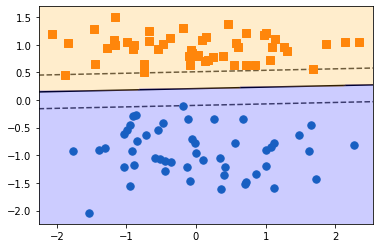

In [72]:
X, y = get_scaled_linearly_separable_data()
axes = [np.min(X[:, 0]) - 0.2, np.max(X[:, 0]) + 0.2, np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2]

hard_margin_clf = HardMarginSVM()
hard_margin_clf.fit(X, y)

plot_scatter(X[:, 0], X[:, 1], y)
plot_margins(hard_margin_clf, axes)
plot_decision_boundary(hard_margin_clf, axes)

     pcost       dcost       gap    pres   dres
 0: -6.1381e+01  1.9342e+02  8e+02  4e+00  2e+01
 1:  9.4877e+01 -1.1595e+00  1e+02  2e-01  1e+00
 2:  3.8503e+01  2.4820e+01  2e+01  3e-02  1e-01
 3:  3.3742e+01  2.9301e+01  5e+00  8e-03  3e-02
 4:  3.2186e+01  3.0945e+01  1e+00  2e-03  7e-03
 5:  3.1740e+01  3.1339e+01  4e-01  5e-04  2e-03
 6:  3.1543e+01  3.1530e+01  1e-02  1e-05  4e-05
 7:  3.1536e+01  3.1536e+01  1e-04  1e-07  4e-07
 8:  3.1536e+01  3.1536e+01  1e-06  1e-09  4e-09
Optimal solution found.


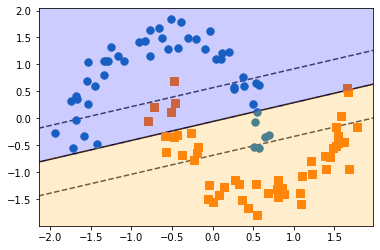

In [73]:
X, y = get_moon_data()
axes = [np.min(X[:, 0]) - 0.2, np.max(X[:, 0]) + 0.2, np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2]

soft_margin_clf = SoftMarginSVM()
soft_margin_clf.fit(X, y)

plot_scatter(X[:, 0], X[:, 1], y)
plot_margins(soft_margin_clf, axes)
plot_decision_boundary(soft_margin_clf, axes)

     pcost       dcost       gap    pres   dres
 0: -1.9811e+01 -2.2442e+00  6e+02  3e+01  1e-15
 1: -7.0037e-01 -2.2327e+00  8e+00  2e-01  1e-15
 2: -5.1863e-01 -1.5521e+00  1e+00  4e-17  3e-16
 3: -5.7629e-01 -6.8295e-01  1e-01  4e-17  3e-16
 4: -6.1559e-01 -6.4354e-01  3e-02  2e-17  2e-16
 5: -6.2698e-01 -6.3109e-01  4e-03  3e-17  2e-16
 6: -6.2873e-01 -6.2939e-01  7e-04  2e-17  2e-16
 7: -6.2901e-01 -6.2909e-01  8e-05  6e-17  3e-16
 8: -6.2905e-01 -6.2905e-01  3e-06  2e-17  3e-16
 9: -6.2905e-01 -6.2905e-01  2e-07  2e-17  2e-16
Optimal solution found.
84 support vectors out of 100 points
     pcost       dcost       gap    pres   dres
 0: -3.8799e+01 -2.0532e+02  9e+02  2e+00  2e-15
 1: -2.6475e+01 -1.2065e+02  1e+02  2e-01  2e-15
 2: -2.6801e+01 -4.1892e+01  2e+01  2e-02  2e-15
 3: -2.9906e+01 -3.5464e+01  6e+00  6e-03  1e-15
 4: -3.0925e+01 -3.3302e+01  3e+00  2e-03  1e-15
 5: -3.1407e+01 -3.2577e+01  1e+00  4e-04  1e-15
 6: -3.1526e+01 -3.2274e+01  8e-01  1e-04  9e-16
 7: -3.180

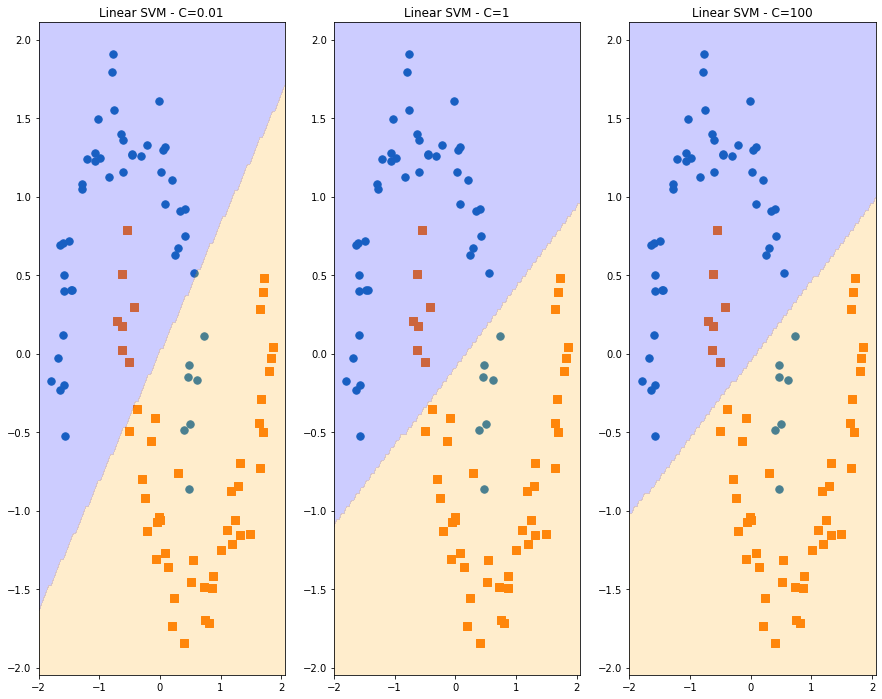

In [74]:
X, y = get_scaled_moon_data()
axes = [np.min(X[:, 0]) - 0.2, np.max(X[:, 0]) + 0.2, np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2]
c_values = [0.01, 1, 100]

plt.figure(figsize=(15, 12))
for i, c in enumerate(c_values):
    plt.subplot(1, 3, i + 1)
    svm_clf = SVM(kernel=linear_kernel, C=c)
    svm_clf.fit(X, y)
    plot_scatter(X[:, 0], X[:, 1], y)
    plot_decision_boundary(svm_clf, axes)
    plt.title(f'Linear SVM - C={c}')

     pcost       dcost       gap    pres   dres
 0: -7.7454e+00 -2.4994e+00  6e+02  2e+01  9e-15
 1: -1.2697e+00 -2.1535e+00  3e+01  1e+00  9e-15
 2: -3.9444e-01 -1.7029e+00  3e+00  7e-02  1e-15
 3: -2.9881e-01 -6.7805e-01  4e-01  2e-17  8e-16
 4: -3.3675e-01 -4.0589e-01  7e-02  2e-17  3e-16
 5: -3.5228e-01 -3.7343e-01  2e-02  2e-17  2e-16
 6: -3.5846e-01 -3.6287e-01  4e-03  2e-17  3e-16
 7: -3.6006e-01 -3.6059e-01  5e-04  2e-17  3e-16
 8: -3.6024e-01 -3.6035e-01  1e-04  2e-17  3e-16
 9: -3.6029e-01 -3.6029e-01  6e-06  2e-17  3e-16
10: -3.6029e-01 -3.6029e-01  1e-07  2e-17  4e-16
Optimal solution found.
48 support vectors out of 100 points
     pcost       dcost       gap    pres   dres
 0: -1.3906e+01 -1.8532e+02  9e+02  2e+00  2e-14
 1: -8.5097e+00 -1.0305e+02  2e+02  3e-01  1e-14
 2: -4.1732e+00 -2.8899e+01  3e+01  4e-02  8e-15
 3: -5.0943e+00 -1.2877e+01  9e+00  1e-02  3e-15
 4: -5.8209e+00 -9.1218e+00  4e+00  4e-03  3e-15
 5: -6.4665e+00 -7.3726e+00  1e+00  5e-04  3e-15
 6: -6.663

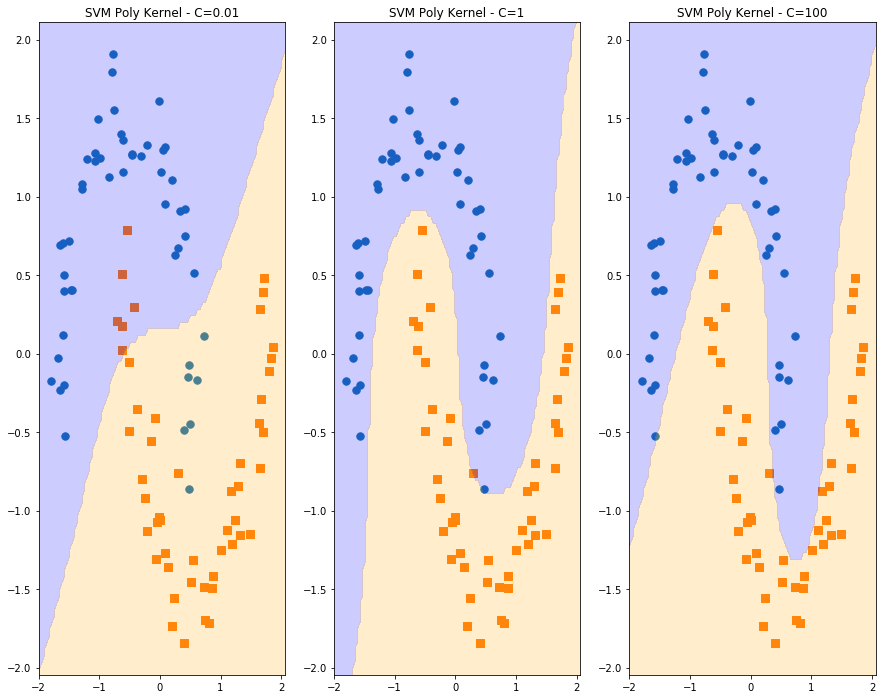

In [75]:
poly_kernel = get_polynomial_kernel()
plt.figure(figsize=(15, 12))
for i, c in enumerate(c_values):
    plt.subplot(1, 3, i + 1)
    svm_clf = SVM(kernel=poly_kernel, C=c);
    svm_clf.fit(X, y);
    plot_scatter(X[:, 0], X[:, 1], y)
    plot_decision_boundary(svm_clf, axes)
    plt.title(f'SVM Poly Kernel - C={c}')

     pcost       dcost       gap    pres   dres
 0: -1.6951e+01 -4.6137e+00  7e+02  3e+01  5e-16
 1: -2.6028e+00 -2.9006e+00  2e+01  8e-01  6e-16
 2: -8.1197e-01 -2.1790e+00  1e+00  8e-17  8e-16
 3: -8.7833e-01 -1.0317e+00  2e-01  2e-17  4e-16
 4: -9.2689e-01 -9.2930e-01  2e-03  3e-17  4e-16
 5: -9.2811e-01 -9.2813e-01  2e-05  3e-17  3e-16
 6: -9.2812e-01 -9.2812e-01  2e-07  2e-17  3e-16
Optimal solution found.
100 support vectors out of 100 points
     pcost       dcost       gap    pres   dres
 0: -2.8520e+01 -2.1305e+02  9e+02  2e+00  8e-16
 1: -2.0734e+01 -1.2512e+02  1e+02  1e-02  9e-16
 2: -2.4308e+01 -3.7344e+01  1e+01  1e-03  7e-16
 3: -2.6488e+01 -3.0669e+01  4e+00  3e-04  6e-16
 4: -2.7356e+01 -2.8954e+01  2e+00  7e-05  6e-16
 5: -2.7661e+01 -2.8396e+01  7e-01  2e-05  6e-16
 6: -2.7817e+01 -2.8063e+01  2e-01  4e-06  6e-16
 7: -2.7873e+01 -2.7956e+01  8e-02  9e-07  6e-16
 8: -2.7902e+01 -2.7914e+01  1e-02  3e-15  6e-16
 9: -2.7907e+01 -2.7907e+01  6e-04  9e-16  6e-16
10: -2.79

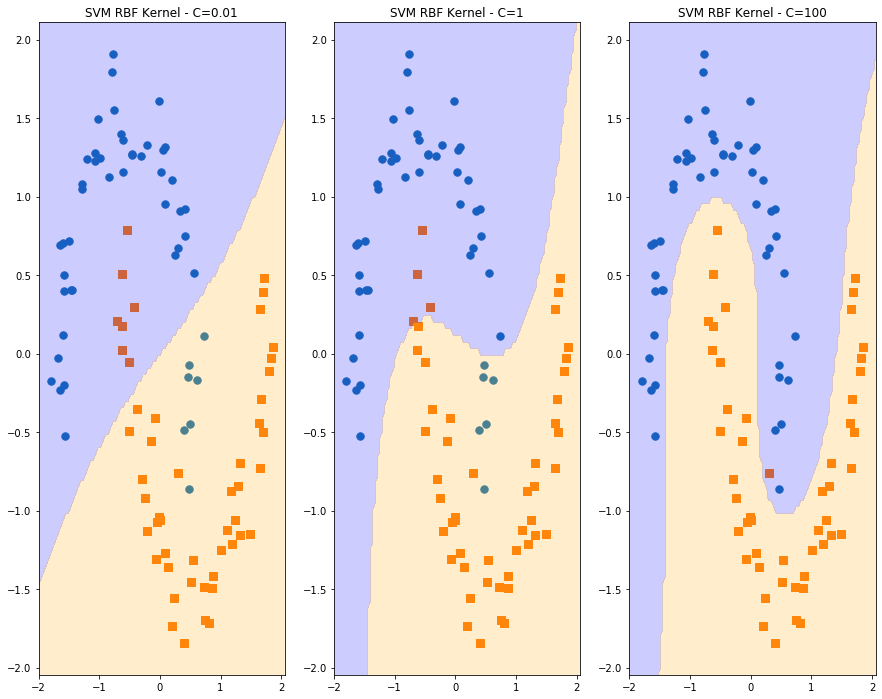

In [76]:
rbf_kernel = get_rbf_kernel()
plt.figure(figsize=(15, 12))
for i, c in enumerate(c_values):
    plt.subplot(1, 3, i + 1)
    svm_clf = SVM(kernel=rbf_kernel, C=c)
    svm_clf.fit(X, y)
    plot_scatter(X[:, 0], X[:, 1], y)
    plot_decision_boundary(svm_clf, axes)
    plt.title(f'SVM RBF Kernel - C={c}')